In [1]:
import matplotlib.pyplot as plt
from time import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition, manifold 
import pickle 
import numpy as np

%matplotlib inline

### Load the data

In [2]:
directory = './data/1/patients/'
file_name = directory + '1_8_5_4_200_0.p'

In [3]:
with open(file_name, 'rb') as f:
    p_array = pickle.load(f)
classes = p_array[:, -1]
print(p_array.shape, classes[(0 == classes)].size, classes[(1 == classes)].size)

(10000, 101) 5000 5000


### Random forest ROC

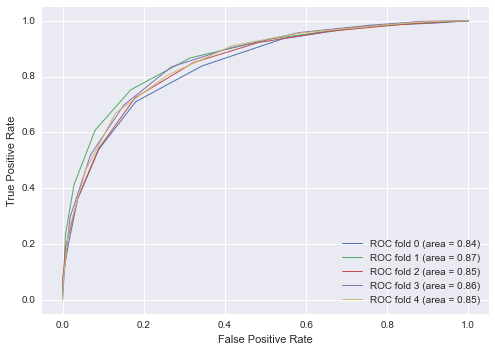

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score
from sklearn.cross_validation import StratifiedKFold

from scipy import interp
import matplotlib.pyplot as plt

from collections import Counter
import seaborn as sns
sns.set(style="darkgrid")

rfc_list = []
svm_list = []

indices = list(range(1, len(p_array)))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

X = p_array[:1000, :-1]
y = p_array[:1000, -1].astype(int)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(iris.target_names))
#     plt.xticks(tick_marks, iris.target_names, rotation=45)
#     plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cv = StratifiedKFold(y, n_folds=5)

for i, (train, test) in enumerate(cv):
    rfc = RandomForestClassifier()
    probas_ = rfc.fit(X[train], y[train]).predict_proba(X[test])
    rfc_predict = rfc.predict(X[test])
#  rfc_list.append(f1_score(y[test], rfc_predict, average='weighted'))
#     rfc_cm = rfc_cm + confusion_matrix(y[test], rfc_predict)
#     print(classification_report(y[test], rfc_predict))
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

### SVM ROC

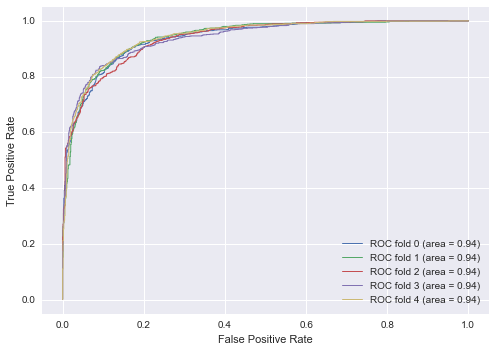

In [5]:
for i, (train, test) in enumerate(cv):
#     clf = SVC(gamma=0.001, C=100., probability=True)
    clf = SVC(probability=True)
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    clf.fit(X[train], y[train])
    svm_predict = clf.predict(X[test])
#     svm_cm = svm_cm + confusion_matrix(y[test], svm_predict)

    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

### Cluster and plot the data

(<matplotlib.figure.Figure at 0x11876bc88>,
  <matplotlib.text.Text at 0x10ffea278>])

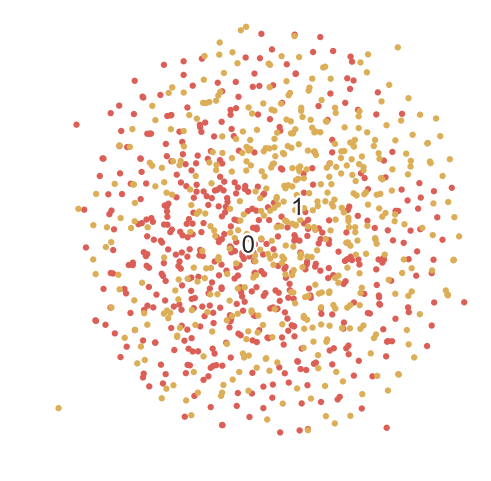

In [6]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150806

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

X = p_array[:1000, :-1]
y = p_array[:1000, -1].astype(int)

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(2):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

X_tsne = np.vstack([X[y==i]
               for i in range(2)])
y_tsne = np.hstack([y[y==i]
               for i in range(2)])

proj2 = TSNE(random_state=RS, init='pca').fit_transform(X_tsne)
scatter(proj2, y_tsne)

In [8]:
import classes.train_dAs as trainer
import theano
import theano.tensor as T

X = p_array[:, :-1]
y = p_array[:, -1].astype(int)

i_theano = T.dmatrix('i_theano')
da = trainer.train_da(X, learning_rate=0.1, coruption_rate=0.2, batch_size=10, training_epochs=1000, n_hidden=2)
get_hidden = da.get_hidden_values(i_theano)
f = theano.function([i_theano], [get_hidden])
x_hidden = f(X)[0]

print(x_hidden.shape)

X_tsne = np.vstack([x_hidden[y==i]
               for i in range(2)])
y_tsne = np.hstack([y[y==i]
               for i in range(2)])

proj2 = TSNE(random_state=RS, init='pca').fit_transform(X_tsne)
scatter(proj2, y_tsne)

ImportError: No module named 'classes.train_dAs'